In [16]:
from flygym.arena import FlatTerrain
from flygym import SingleFlySimulation, Camera, Fly
from flygym.examples.vision import ObstacleOdorArena
import numpy as np

import matplotlib.pyplot as plt

In [27]:
class LoomingBallArena(FlatTerrain):
    def __init__(self, timestep, fly, ball_radius=1.0, ball_approach_vel=50,
    ball_approach_start_radius=10, looming_lambda=0.5, seed=0, approach_angles=[-5*np.pi/4, 5*np.pi/4], **kwargs):
        super().__init__(**kwargs)

        self.seed = seed
        self.random_state = np.random.RandomState(self.seed)
        self.p_no_looming = np.exp(-looming_lambda * timestep)

        self.ball_approach_vel = ball_approach_vel
        self.ball_approach_start_radius = ball_approach_start_radius
        interception_time = ball_approach_start_radius / ball_approach_vel
        self.dt = timestep
        self.n_interception_steps = int(interception_time / self.dt)
        self.ball_trajectory = np.zeros((self.n_interception_steps, 2))
        self.ball_approach_angles = approach_angles

        self.ball_rest_height = 10.0
        self.ball_act_height = -self.ball_rest_height + ball_radius + self._get_max_floor_height()

        self.is_looming = False
        self.ball_traj_advancement = 0

        self.fly = fly
        self.add_ball(ball_radius)

        # implement a fixed length fifo style buffer for fly velocities
        self.vel_buffer_size = 100
        self.fly_velocities = np.ones((self.vel_buffer_size , 2))*np.nan
        self.fly_velocities_idx = 0

    def add_ball(self, ball_radius):

        self.ball_body = self.root_element.worldbody.add(
            'body', name='ball', pos=[0, 0, self.ball_rest_height]
        )
        self.ball_jointx = self.ball_body.add(
            "joint", name="ball_jointx", type="slide", axis=[1, 0, 0], damping=0.01
        )
        self.ball_jointy = self.ball_body.add(
            "joint", name="ball_jointy", type="slide", axis=[0, 1, 0], damping=0.01
        )
        self.ball_jointz = self.ball_body.add(
            "joint", name="ball_jointz", type="slide", axis=[0, 0, 1], damping=0.01
        )
        # self.ball_actx = self.root_element.actuator.add(
        #     "position", name="ball_act", joint=self.ball_jointx.name, kp=100, forcelimited=False
        # )
        # self.ball_acty = self.root_element.actuator.add(
        #     "position", name="ball_acty", joint=self.ball_jointy.name, kp=100, forcelimited=False
        # )
        # self.ball_actz = self.root_element.actuator.add(
        #     "position", name="ball_actz", joint=self.ball_jointz.name, kp=100, forcelimited=False
        # )
        self.ball_geom = self.ball_body.add("geom", name="ball", type='sphere', size=[ball_radius], rgba=[1, 0, 0, 0])

    def spawn_entity(
        self, entity, rel_pos, rel_angle):
        super().spawn_entity(
            entity, rel_pos, rel_angle
        )
        self.add_contacts()

    def add_contacts(self):
        ball_geom_name = self.ball_geom.name
        for animat_geom_name in ["Head", "Thorax", "A1A2", "A3", "A4", "A5", "A6"]:
            self.root_element.contact.add(
                            "pair",
                            name=f"{ball_geom_name}_{self.fly.name}_{animat_geom_name}",
                            geom1=f"{self.fly.name}/{animat_geom_name}",
                            geom2=f"{ball_geom_name}",
                        )
    
    def set_ball_trajectory(self, start_pts, end_pts):
        # set the ball trajectory
        self.ball_trajectory = np.linspace(start_pts, end_pts, self.n_interception_steps)

    def make_ball_visible(self, physics):
        physics.bind(self.ball_geom).rgba[3] = 1
        # make the ball visible

    def make_ball_invisible(self, physics):
        physics.bind(self.ball_geom).rgba[3] = 0
        # make the ball invisible
    
    def move_ball(self, physics, x, y, z):
        # move the ball to the given position
        # physics.bind(self.ball_actx).ctrl = x
        # physics.bind(self.ball_acty).ctrl = y
        # physics.bind(self.ball_actz).ctrl = z
        physics.bind(self.ball_jointx).qpos = x
        physics.bind(self.ball_jointy).qpos = y
        physics.bind(self.ball_jointz).qpos = z

    def step(self, dt, physics):
        # update the fly velocities
        fly_vel = physics.bind(self.fly._body_sensors[0]).sensordata[:2].copy()
        self.fly_velocities[self.fly_velocities_idx%self.vel_buffer_size, :] = fly_vel
        self.fly_velocities_idx += 1


        # poisson process
        if self.random_state.rand() > self.p_no_looming and not self.is_looming:
            self.is_looming = True
            self.ball_traj_advancement = 0
            self.make_ball_visible(physics)

            # set the ball trajectory
            fly_pos = physics.bind(self.fly._body_sensors[0]).sensordata[:2].copy()
            fly_or_vec = physics.bind(self.fly._body_sensors[4]).sensordata.copy()
            fly_roll = np.arctan2(fly_or_vec[1], fly_or_vec[0])
            rel_approach_angle = self.ball_approach_angles + fly_roll
            start_angle = self.random_state.uniform(low=rel_approach_angle[0], high=rel_approach_angle[1])

            fly_vel = np.nanmean(self.fly_velocities, axis=0)
            fly_interception_pos = fly_pos + fly_vel * self.n_interception_steps * self.dt
            start_x = fly_interception_pos[0] + self.ball_approach_start_radius * np.cos(start_angle)
            start_y = fly_interception_pos[1] + self.ball_approach_start_radius * np.sin(start_angle)
            start_pts = np.array([start_x, start_y])
            self.set_ball_trajectory(start_pts, fly_interception_pos)
            self.move_ball(physics, start_x, start_y, -self.ball_act_height)
            self.ball_traj_advancement += 1

            # plt.scatter(fly_pos[0], fly_pos[1], label='fly pos', s=5)
            # plt.scatter(fly_interception_pos[0], fly_interception_pos[1], label='fly interception pos', s=5)
            # plt.plot(self.ball_trajectory[:, 0], self.ball_trajectory[:, 1], label='ball trajectory')
            # plt.scatter(start_x, start_y, label='ball start pos', s=5)
            # plt.arrow(fly_pos[0], fly_pos[1], fly_vel[0], fly_vel[1], head_width=0.5, head_length=0.5, fc='blue', ec='blue')
            # plt.arrow(fly_interception_pos[0], fly_interception_pos[1], fly_or_vec[0], fly_or_vec[1], head_width=0.5, head_length=0.5, fc='green', ec='green')
            # plt.legend()
            # plt.show()
            

        elif self.is_looming:
            self.move_ball(
                physics,
                self.ball_trajectory[self.ball_traj_advancement, 0],
                self.ball_trajectory[self.ball_traj_advancement, 1],
                self.ball_act_height
                )
            self.ball_traj_advancement += 1
            if self.ball_traj_advancement >= self.n_interception_steps:
                self.is_looming = False
                self.make_ball_invisible(physics)
                self.move_ball(physics, 0, 0, self.ball_rest_height)
        else:
            # move the ball to the rest height
            self.move_ball(physics, 0, 0, self.ball_rest_height)

    
    def reset(self, physics, seed=None):
        if not seed is None:
            self.seed = seed

        self.random_state = np.random.RandomState(self.seed)
        
        self.is_looming = False
        self.make_ball_invisible(physics)
        self.ball_traj_advancement = 0
        self.ball_trajectory = np.zeros((self.n_interception_steps, 2))
        # set the ball position to the rest height
        self.move_ball(physics, 0, 0, self.ball_rest_height)

Spawning fly at [0.01634914 0.00730949 1.7814164 ] mm


 27%|██▋       | 2737/10000 [00:09<00:22, 317.06it/s]

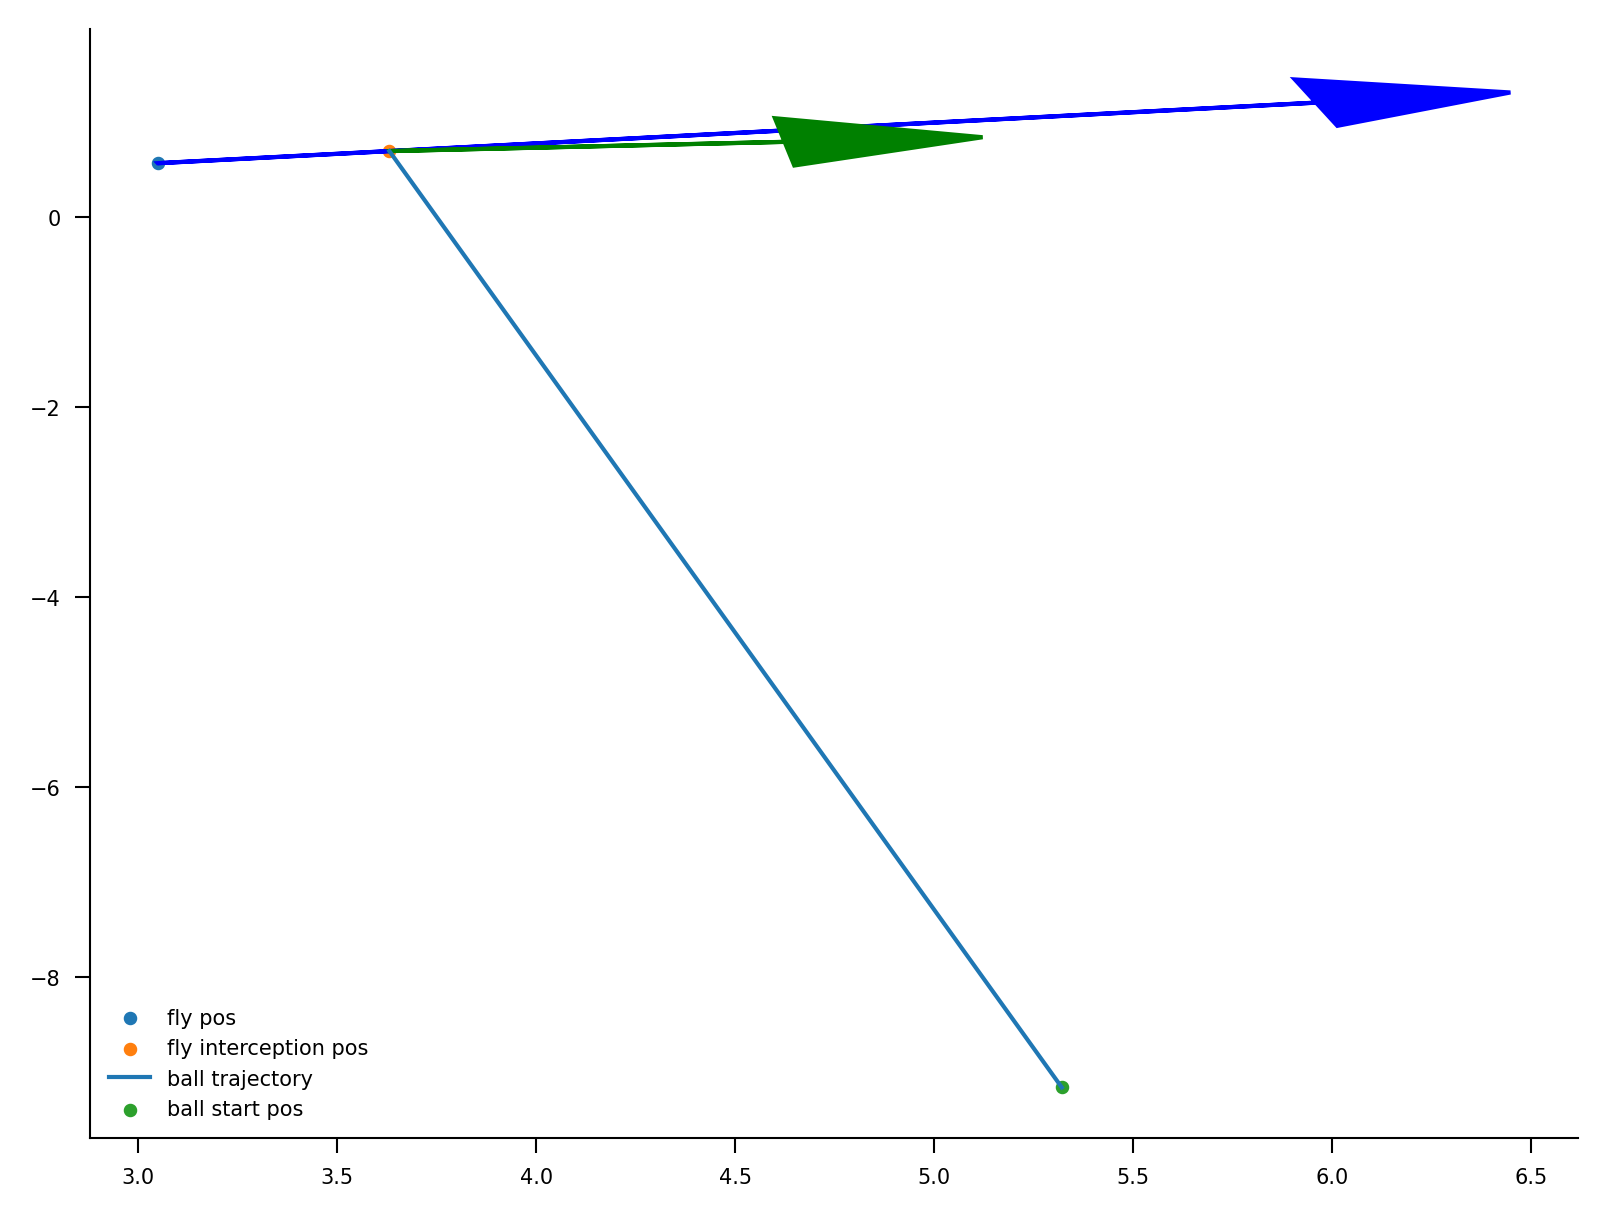

 51%|█████     | 5061/10000 [00:17<00:17, 279.02it/s]

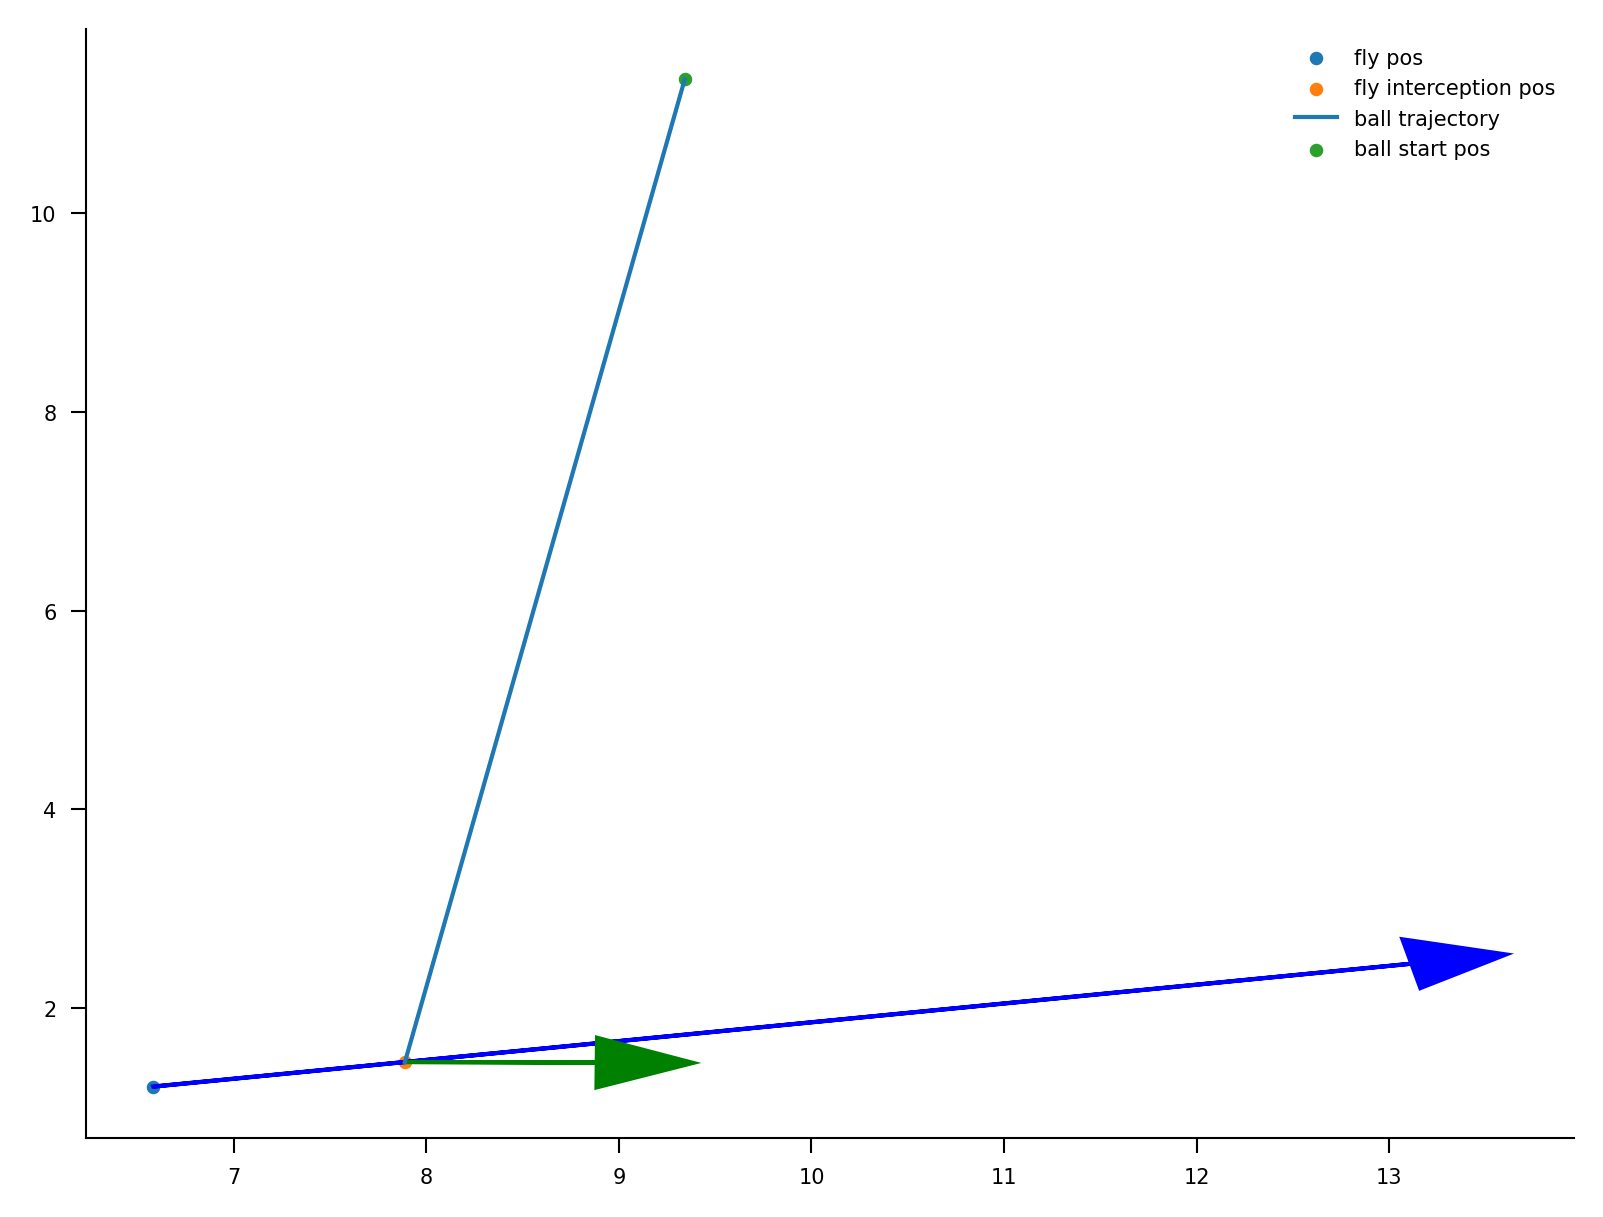

 81%|████████▏ | 8131/10000 [00:28<00:05, 313.34it/s]

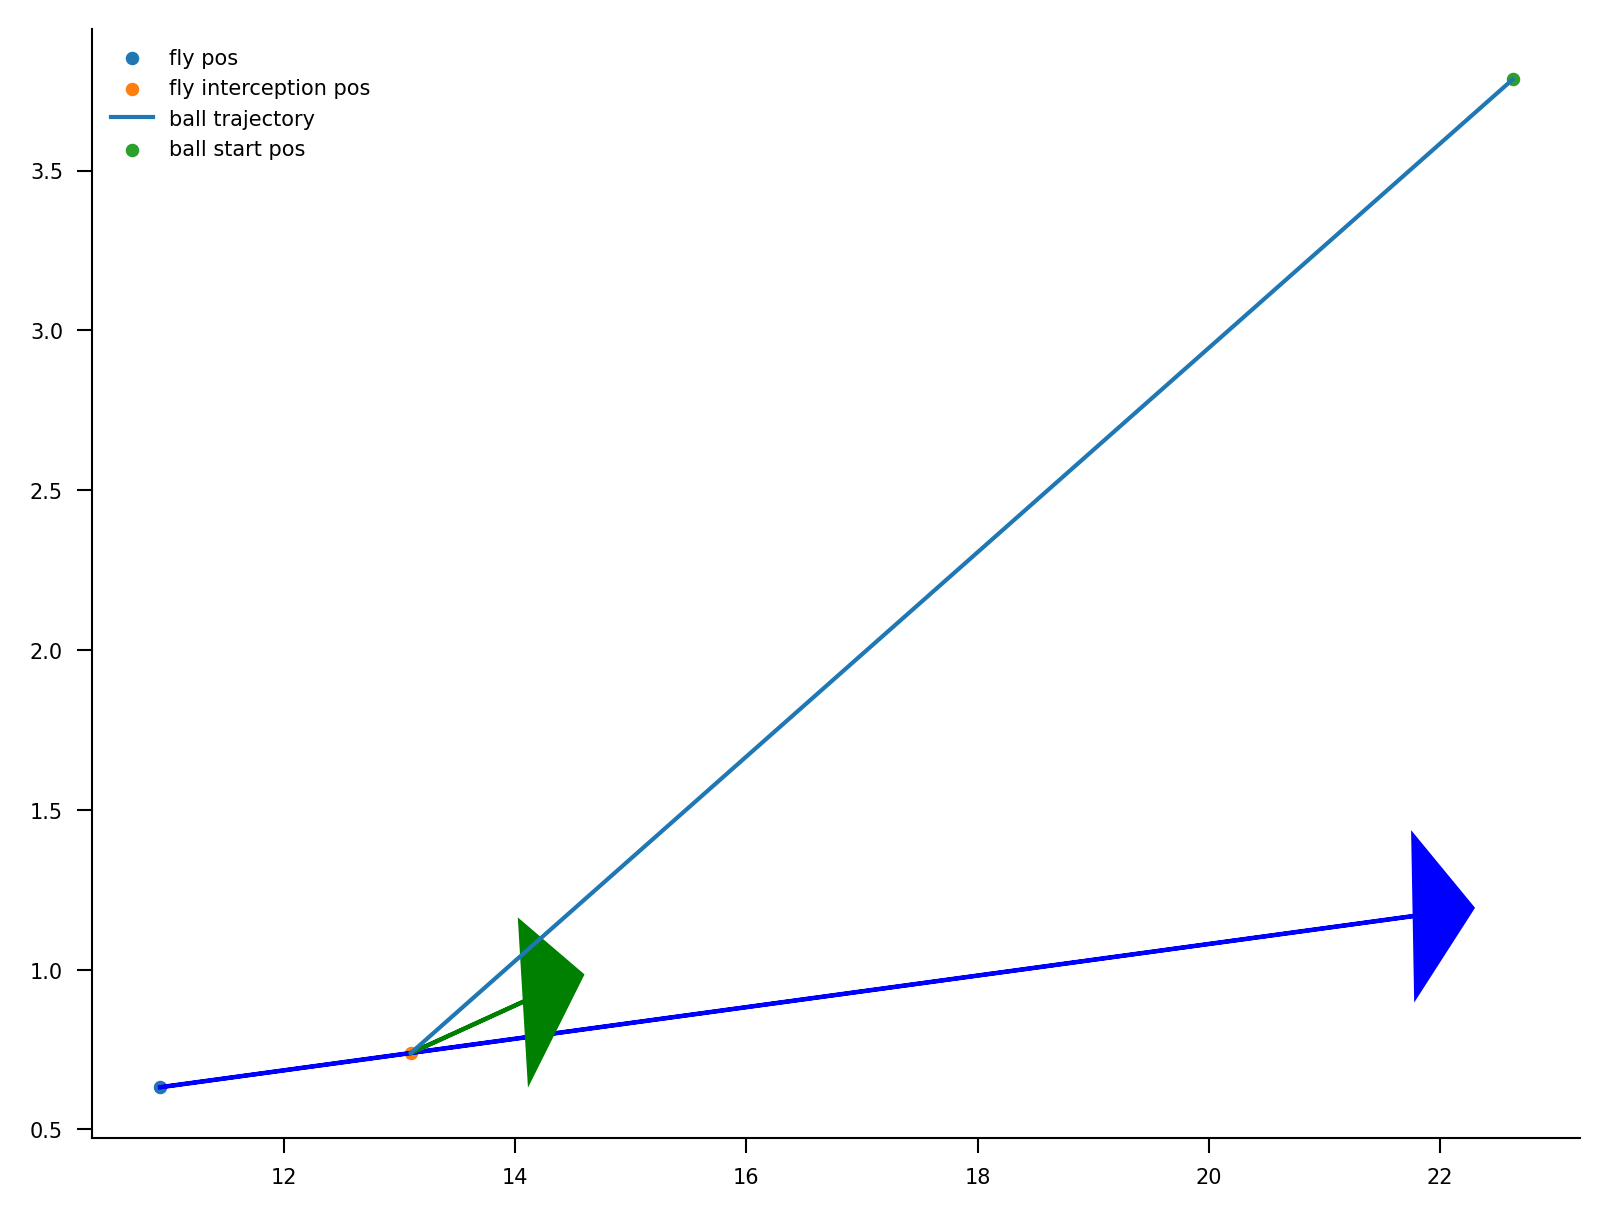

 99%|█████████▊| 9857/10000 [00:34<00:00, 286.59it/s]


Simulation was interrupted because of a physics error
Final x position: 12.8905 mm
Simulation terminated: [12.874067    0.38612604 -0.8758626 ]


In [26]:
from flygym.examples.locomotion import HybridTurningFly
from flygym import YawOnlyCamera
from tqdm import trange
from dm_control.rl.control import PhysicsError


run_time = 1.0
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

np.random.seed(0)

fly = HybridTurningFly(
    enable_adhesion=True,
    draw_adhesion=True,
    contact_sensor_placements=contact_sensor_placements,
    seed=0,
    draw_corrections=True,
    timestep=timestep,
)

arena = LoomingBallArena(timestep, fly)

cam = YawOnlyCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
)


sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

obs_list = []

obs, info = sim.reset(seed=0)
print(f"Spawning fly at {obs['fly'][0]} mm")

for i in trange(int(run_time / sim.timestep)):
    curr_time = i * sim.timestep
    action = np.array([1.0, 1.0])
    try:
        obs, reward, terminated, truncated, info = sim.step(action)
        obs_list.append(obs)
        sim.render()
    except PhysicsError:
        print("Simulation was interrupted because of a physics error")
        break

x_pos = obs_list[-1]["fly"][0][0]
print(f"Final x position: {x_pos:.4f} mm")
print(f"Simulation terminated: {obs_list[-1]['fly'][0] - obs_list[0]['fly'][0]}")

cam.save_video("./outputs/ball_arena.mp4", 0)